Connect to Google Drive


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd drive/MyDrive/instadeep/InstaDeep/

/content/drive/MyDrive/instadeep/InstaDeep


Packages import

In [3]:
from data import features,get_dataset
from model import classifier
import tqdm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

GPU

In [4]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Data processing

In [5]:
path="random_split/"

test,val,train =get_dataset.get_df(path)

#Due to limitation of computing capacities, we will only consider the 1000 most important classes
classes=features.get_classes_top1000(train)
#apply those changes to train, test, val
test=features.reduce_dataset_1000topclasses(test,classes)
train=features.reduce_dataset_1000topclasses(train,classes)
val=features.reduce_dataset_1000topclasses(val,classes)

#Process inputs 
train_processed=features.process_dataset(train, classes)
test_processed=features.process_dataset(test, classes)
val_processed=features.process_dataset(val, classes)
print(train_processed.shape)
print(test_processed.shape)
print(val_processed.shape)
#Process labels
y_train=features.process_labels(train,classes)
y_test=features.process_labels(test,classes)
y_val=features.process_labels(val,classes)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(439493, 100)
(54378, 100)
(54378, 100)
(439493, 1000)
(54378, 1000)
(54378, 1000)


Simple model : using LSTM

In [6]:
model=classifier.build_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          2100      
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               160800    
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 1000)              201000    
Total params: 363,900
Trainable params: 363,900
Non-trainable params: 0
_________________________________________________________________
None


In [7]:
history=classifier.train_model(model,train_processed,y_train,val_processed,y_val,epochs=50)


Epoch 1/50
1717/1717 [==============================] - 57s 28ms/step - loss: 7.3651 - accuracy: 0.0388 - val_loss: 3.8523 - val_accuracy: 0.2815
Epoch 2/50
1717/1717 [==============================] - 47s 28ms/step - loss: 3.5390 - accuracy: 0.3332 - val_loss: 2.0374 - val_accuracy: 0.6770
Epoch 3/50
1717/1717 [==============================] - 47s 27ms/step - loss: 2.1719 - accuracy: 0.6129 - val_loss: 1.3491 - val_accuracy: 0.8110
Epoch 4/50
1717/1717 [==============================] - 47s 28ms/step - loss: 1.6131 - accuracy: 0.7241 - val_loss: 1.0533 - val_accuracy: 0.8629
Epoch 5/50
1717/1717 [==============================] - 47s 27ms/step - loss: 1.3350 - accuracy: 0.7786 - val_loss: 0.8715 - val_accuracy: 0.8920
Epoch 6/50
1717/1717 [==============================] - 47s 27ms/step - loss: 1.1747 - accuracy: 0.8085 - val_loss: 0.7513 - val_accuracy: 0.9116
Epoch 7/50
1717/1717 [==============================] - 47s 27ms/step - loss: 1.1140 - accuracy: 0.8187 - val_loss: 0.6856 -

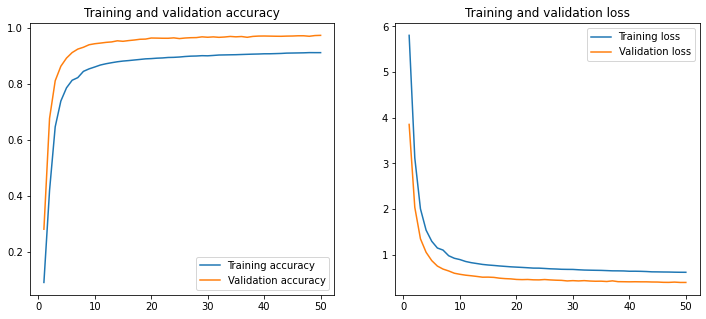

In [8]:
classifier.plot_accuracy_train_val(history)

In [9]:
result=model.evaluate(test_processed,y_test)

1700/1700 [==============================] - 11s 6ms/step - loss: 0.3956 - accuracy: 0.9720


ProtCNN

In [10]:
#additional preprocessing 
train_2=features.additional_process(train_processed)
val_2=features.additional_process(val_processed)
test_2=features.additional_process(test_processed)


In [11]:
model2=classifier.protccn_model(input_shape=train_2.shape)
print(model2.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (439493, 100, 128)        2816      
_________________________________________________________________
sequential_2 (Sequential)    (439493, 100, 128)        66816     
_________________________________________________________________
sequential_3 (Sequential)    (439493, 100, 128)        66816     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (439493, 33, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (439493, 33, 128)         0         
_________________________________________________________________
flatten (Flatten)            (439493, 4224)            0         
_________________________________________________________________
dense_1 (Dense)              (439493, 1000)           

In [12]:
history2=classifier.train_model(model2,train_2,y_train,val_2,y_val,epochs=50,model_name="protCNN")

Epoch 1/50
1717/1717 [==============================] - 54s 30ms/step - loss: 1.6644 - accuracy: 0.8268 - val_loss: 0.4197 - val_accuracy: 0.9856
Epoch 2/50
1717/1717 [==============================] - 50s 29ms/step - loss: 0.3863 - accuracy: 0.9838 - val_loss: 0.4292 - val_accuracy: 0.9838
Epoch 3/50
1717/1717 [==============================] - 50s 29ms/step - loss: 0.4043 - accuracy: 0.9839 - val_loss: 0.4313 - val_accuracy: 0.9849
Epoch 4/50
1717/1717 [==============================] - 50s 29ms/step - loss: 0.4028 - accuracy: 0.9847 - val_loss: 0.4384 - val_accuracy: 0.9833
Epoch 5/50
1717/1717 [==============================] - 50s 29ms/step - loss: 0.3924 - accuracy: 0.9860 - val_loss: 0.4246 - val_accuracy: 0.9857
Epoch 6/50
1717/1717 [==============================] - 50s 29ms/step - loss: 0.3894 - accuracy: 0.9859 - val_loss: 0.4171 - val_accuracy: 0.9854
Epoch 7/50
1717/1717 [==============================] - 50s 29ms/step - loss: 0.3801 - accuracy: 0.9864 - val_loss: 0.4066 -

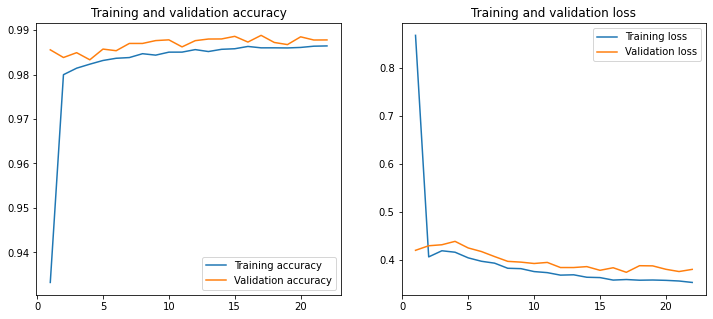

In [13]:
classifier.plot_accuracy_train_val(history2)

In [14]:
result=model2.evaluate(test_2,y_test)

1700/1700 [==============================] - 6s 3ms/step - loss: 0.3820 - accuracy: 0.9872
